<a href="https://colab.research.google.com/github/archyyu/GPT-from-MLP-to-RNN-to-Transformer/blob/main/GPT_by_RNN_with_attention_version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

# Set random seed for reproducibility
torch.manual_seed(42)

In [2]:
# Data I/O

url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
#url = "https://raw.githubusercontent.com/archyyu/publicResource/main/google.dev.en"
#url = "https://raw.githubusercontent.com/torvalds/linux/master/mm/madvise.c"
response = requests.get(url)
data = response.text

chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print(f'data has {data_size} characters, {vocab_size} unique.')

char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

data has 1115394 characters, 65 unique.


In [3]:
# Hyperparameters
hidden_size = 100
embedding_dim = 20
seq_length = 25
learning_rate = 1e-1
batch_size = 20

In [4]:
class Attention(nn.Module):
  def __init__(self, hidden_size):
    super(Attention, self).__init__()
    self.attn = nn.Linear(hidden_size * 2, hidden_size)
    self.v = nn.Parameter(torch.rand(hidden_size))

  def forward(self, hidden, encoder_outputs):
    seq_len = encoder_outputs.size(1)
    hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)
    energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=-1)))
    attention_scores = torch.matmul(energy, self.v)
    attention_weights = torch.softmax(attention_scores, dim=1)
    context_vector = torch.sum(attention_weights.unsqueeze(2) * encoder_outputs, dim=1)
    return context_vector

class ManillaRNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size):
    super(ManillaRNN, self).__init__()
    self.hidden_size = hidden_size
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.i2h = nn.Linear(embedding_dim, hidden_size, bias=False)
    self.h2h = nn.Linear(hidden_size, hidden_size, bias=False)
    self.h2o = nn.Linear(hidden_size, vocab_size, bias=False)
    self.e2d = nn.Linear(hidden_size, vocab_size, bias=False)
    self.hb2 = nn.Parameter(torch.zeros(1, hidden_size))
    self.ob = nn.Parameter(torch.zeros(1, vocab_size))
    self.attention = Attention(hidden_size)

  def forward(self, x):
    h = torch.zeros(x.shape[0], self.hidden_size)
    y_list = []
    h_list = []
    h_list.append(h)
    for i in range(x.shape[1]):
      t = self.embedding(x[:,i])
      h = torch.tanh(self.i2h(t) + self.h2h(h) + self.hb2)
      h_list.append(h)
      cxt = self.attention(h, torch.stack(h_list, dim=1))
      y = self.e2d(cxt) + self.h2o(h) + self.ob
      y_list.append(y)
    return torch.stack(y_list, dim=1);


criterion = nn.CrossEntropyLoss()

model = ManillaRNN(vocab_size, embedding_dim, hidden_size)
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

Now tusi ManillaRNN is different with the VanillaRNN.
It will iterate all the time step, drop the intermediate output, and only output the final one.

But I am not going to rewrite the training function to retrain the new model.
Because I think the VanillaRNN is more better and controlable than this one.


In [6]:
def getBatch():
  batch_inputs = []
  batch_targets = []

  start_idx = torch.randint(len(data) - batch_size - seq_length - 2,[1]).item()

  # Generate examples for the current minibatch
  for i in range(batch_size):
    p = start_idx + i
    inputs = torch.tensor([char_to_ix[ch] for ch in data[p:p + seq_length]], dtype=torch.long).view(1, -1)
    targets = torch.tensor([char_to_ix[ch] for ch in data[p + 1:p + seq_length + 1]], dtype=torch.long).view(-1)

    batch_inputs.append(inputs)
    batch_targets.append(targets)

  # Convert lists to tensors
  minibatch_inputs = torch.cat(batch_inputs, dim=0)
  minibatch_targets = torch.stack(batch_targets)
  return minibatch_inputs, minibatch_targets

In [7]:
stopi = []
lossi = []

In [10]:
# Training loop
num_iterations = 10000
for iteration in range(num_iterations, num_iterations * 2):

  inputs, targets = getBatch()
  predicts = model(inputs)
  optimizer.zero_grad()
  B,T = targets.shape

  totalloss = criterion(predicts.view(B*T, -1), targets.view(B*T))
  totalloss.backward()
  optimizer.step()

  if iteration % 1000 == 0:
    print(f'Iteration {iteration}, Loss: {totalloss}')
    stopi.append(iteration)
    lossi.append(totalloss.item())


Iteration 10000, Loss: 2.1800272464752197
Iteration 11000, Loss: 2.3864083290100098
Iteration 12000, Loss: 2.0877020359039307
Iteration 13000, Loss: 1.684799075126648
Iteration 14000, Loss: 1.7246509790420532
Iteration 15000, Loss: 2.015029191970825
Iteration 16000, Loss: 1.7445600032806396
Iteration 17000, Loss: 2.153332471847534
Iteration 18000, Loss: 1.587939739227295
Iteration 19000, Loss: 1.9100979566574097


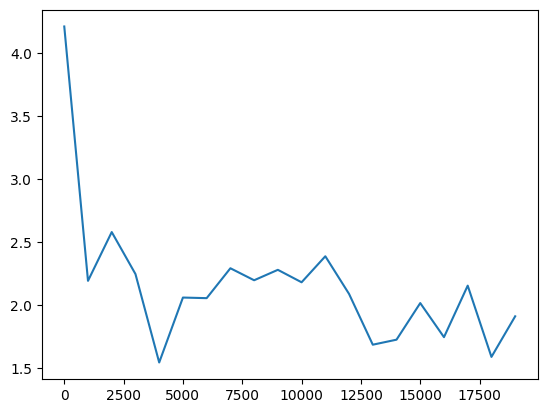

In [11]:
plt.plot(stopi, lossi)

In [15]:
with torch.no_grad():

  start = ['F']
  result = ['F']

  for i in range(2000):
    start = start[-seq_length:]
    ilist = torch.tensor([char_to_ix[i] for i in start])
    ilist = ilist.reshape(1, -1)
    outputs = model(ilist)

    p = nn.functional.softmax(outputs[:,-1,:], dim=-1).detach().numpy().ravel()
    ix = np.random.choice(range(vocab_size), p=p)
    start.append(ix_to_char[ix])
    result.append(ix_to_char[ix])

  print(''.join(result))

Ferel.

PETRUMIO:
Coit!

PETES:
Nound our figher gram ingbondes stiltelt a Ghalent reris;
Rons andins. the bering stinood, thald denvell OFIXINGO:
Promer Pow siy not,
Sirt with doingent septent; it dranit of Pitlounh Bad it the whisonghed lenina:
Mell, let lofg
he to mepeine seef.

COLIZORIZALUS:
May.
S,
But whoum a trupacee.
Yiss.

SOMPED:
Mears I filrown tell in
thou taun prome alonch mens. Saadfightyed everwood noblear grath nnow insies mest chan?

HELLOCKIZAUKISFABES:
Yezericw.

MONE EDY URY EQUTIMOO:
O ke liepguert thou deatisy fe mpies soefore came 'ff let,
Somberffore:
The prean ceforrervideffovise tweuld?

EOMER:
Heres that stand to both; aband her:
I shall, Pratk and 'fert the whRipnen'd the gow thernf will and to
Their cyons aet; steefute thy, of tithars tond thrire.
Sir 'twerst gousss, not to ser, thy per;
and foainter enjind thigher his that dave ogemaitsead as I sebay wall plallere conisloo the nets of for odemarths,
Sath,
ANd of mothee not the shands you. Core.

DOCINIOLE

The new idea is that.

I always use the last time step as the final output of the RNN, or as the predict character of the previous input. we could go further as that, add attention in the final step, to focus differently on the previous tokens to decide what to predict, let do that.

finnally, I add attention to every time step, to focus differently on the previouse tokens

the result is better now.

But how could I compared with GRU and LSTM

now I would like add eva data to value the model